




# asyncio 101 - Python Cooperativo

Cuando se habla de concurrencia se suele hablar de dos conceptos, IO-bound y CPU-bound.

## CPU-bound

Tareas de cómputo que requieren intensamente el CPU. Operaciones matemáticas, cálculo científico, etc.

Se pueden optimizar aplicando **paralelismo** (tareas ejecutadas a la vez en distintos CPU cores).

## IO-bound

Tareas que requieren operaciones de entrada/salida. Vamos a enfocarnos en estas.

Ocurre cuando hay por ejemplo:
- lectura/escritura de archivos 
- comunicación server/client
- requests a API externas
- consultas a DB
- etc

Cuando existe una operacion de I/O, el CPU se queda **esperando**.

Este escenario se puede optimizar con **concurrencia**. Las tareas podrían ejecutarse concurrentemente.

## Ejemplo simple y sincrónico

In [12]:
import requests

In [9]:
def fetch(session, url):
    response = session.get(url)
    print(f"[{response.status_code}] {url}")

In [7]:
urls = [
    f"https://jsonplaceholder.typicode.com/posts/{i}"
    for i in range(1, 20)
]

In [8]:
urls

['https://jsonplaceholder.typicode.com/posts/1',
 'https://jsonplaceholder.typicode.com/posts/2',
 'https://jsonplaceholder.typicode.com/posts/3',
 'https://jsonplaceholder.typicode.com/posts/4',
 'https://jsonplaceholder.typicode.com/posts/5',
 'https://jsonplaceholder.typicode.com/posts/6',
 'https://jsonplaceholder.typicode.com/posts/7',
 'https://jsonplaceholder.typicode.com/posts/8',
 'https://jsonplaceholder.typicode.com/posts/9',
 'https://jsonplaceholder.typicode.com/posts/10',
 'https://jsonplaceholder.typicode.com/posts/11',
 'https://jsonplaceholder.typicode.com/posts/12',
 'https://jsonplaceholder.typicode.com/posts/13',
 'https://jsonplaceholder.typicode.com/posts/14',
 'https://jsonplaceholder.typicode.com/posts/15',
 'https://jsonplaceholder.typicode.com/posts/16',
 'https://jsonplaceholder.typicode.com/posts/17',
 'https://jsonplaceholder.typicode.com/posts/18',
 'https://jsonplaceholder.typicode.com/posts/19']

In [9]:
def fetch_urls():
    session = requests.Session()
    for url in urls:
        fetch(session, url)

In [10]:
%time fetch_urls()

[200] https://jsonplaceholder.typicode.com/posts/1
[200] https://jsonplaceholder.typicode.com/posts/2
[200] https://jsonplaceholder.typicode.com/posts/3
[200] https://jsonplaceholder.typicode.com/posts/4
[200] https://jsonplaceholder.typicode.com/posts/5
[200] https://jsonplaceholder.typicode.com/posts/6
[200] https://jsonplaceholder.typicode.com/posts/7
[200] https://jsonplaceholder.typicode.com/posts/8
[200] https://jsonplaceholder.typicode.com/posts/9
[200] https://jsonplaceholder.typicode.com/posts/10
[200] https://jsonplaceholder.typicode.com/posts/11
[200] https://jsonplaceholder.typicode.com/posts/12
[200] https://jsonplaceholder.typicode.com/posts/13
[200] https://jsonplaceholder.typicode.com/posts/14
[200] https://jsonplaceholder.typicode.com/posts/15
[200] https://jsonplaceholder.typicode.com/posts/16
[200] https://jsonplaceholder.typicode.com/posts/17
[200] https://jsonplaceholder.typicode.com/posts/18
[200] https://jsonplaceholder.typicode.com/posts/19
CPU times: user 421 m

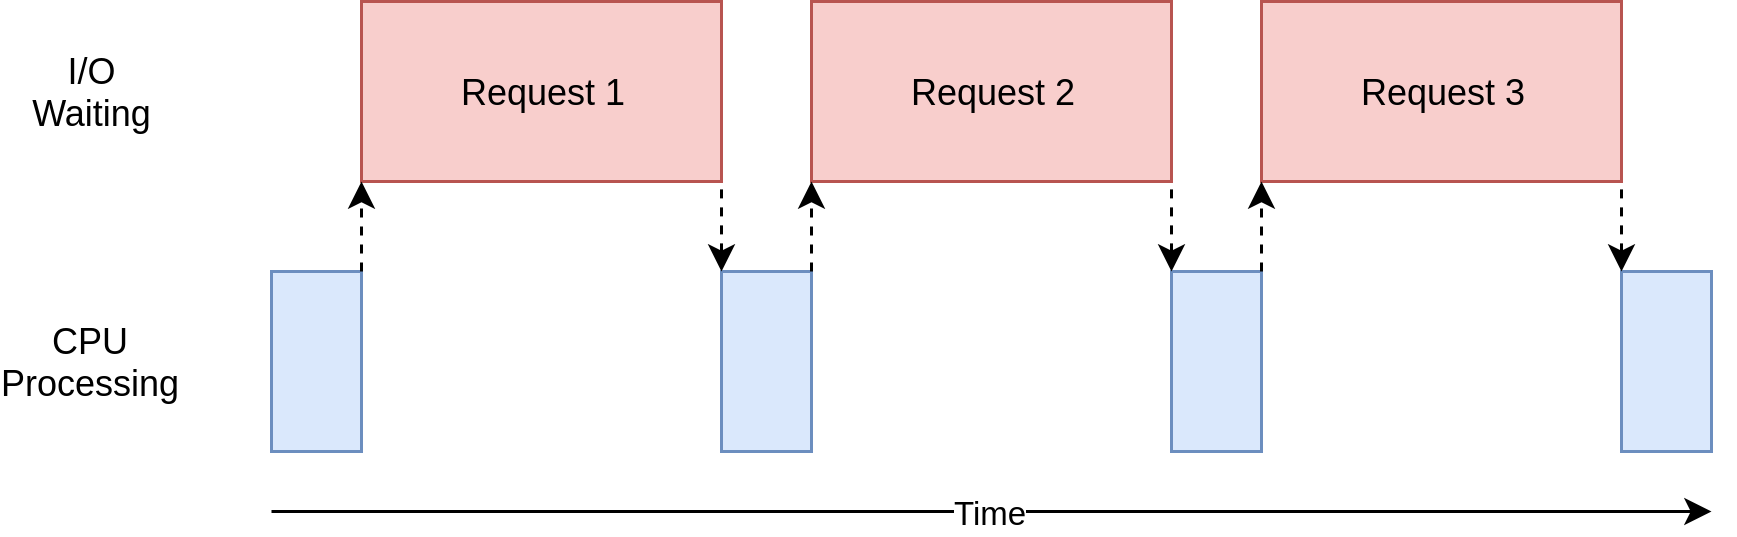

## Ejemplo usando threads

In [11]:
import concurrent.futures

In [12]:
def fetch_urls_with_threads(limit=None):
    session = requests.Session()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=limit) as executor:
        tasks = [
            executor.submit(fetch, session, url)
            for url in urls
        ]
        concurrent.futures.wait(tasks)

`ThreadPoolExecutor` nos provee un context manager, para abstraernos de la creacion y liberación (start, join, close) de los threads.

In [13]:
%time fetch_urls_with_threads(3)

[200] https://jsonplaceholder.typicode.com/posts/3
[200] https://jsonplaceholder.typicode.com/posts/2
[200] https://jsonplaceholder.typicode.com/posts/1
[200] https://jsonplaceholder.typicode.com/posts/4
[200] https://jsonplaceholder.typicode.com/posts/5
[200] https://jsonplaceholder.typicode.com/posts/6
[200] https://jsonplaceholder.typicode.com/posts/7
[200] https://jsonplaceholder.typicode.com/posts/8[200] https://jsonplaceholder.typicode.com/posts/9

[200] https://jsonplaceholder.typicode.com/posts/10
[200] https://jsonplaceholder.typicode.com/posts/11
[200] https://jsonplaceholder.typicode.com/posts/12
[200] https://jsonplaceholder.typicode.com/posts/13
[200] https://jsonplaceholder.typicode.com/posts/14
[200] https://jsonplaceholder.typicode.com/posts/16
[200] https://jsonplaceholder.typicode.com/posts/17
[200] https://jsonplaceholder.typicode.com/posts/18
[200] https://jsonplaceholder.typicode.com/posts/19
[200] https://jsonplaceholder.typicode.com/posts/15
CPU times: user 466 m

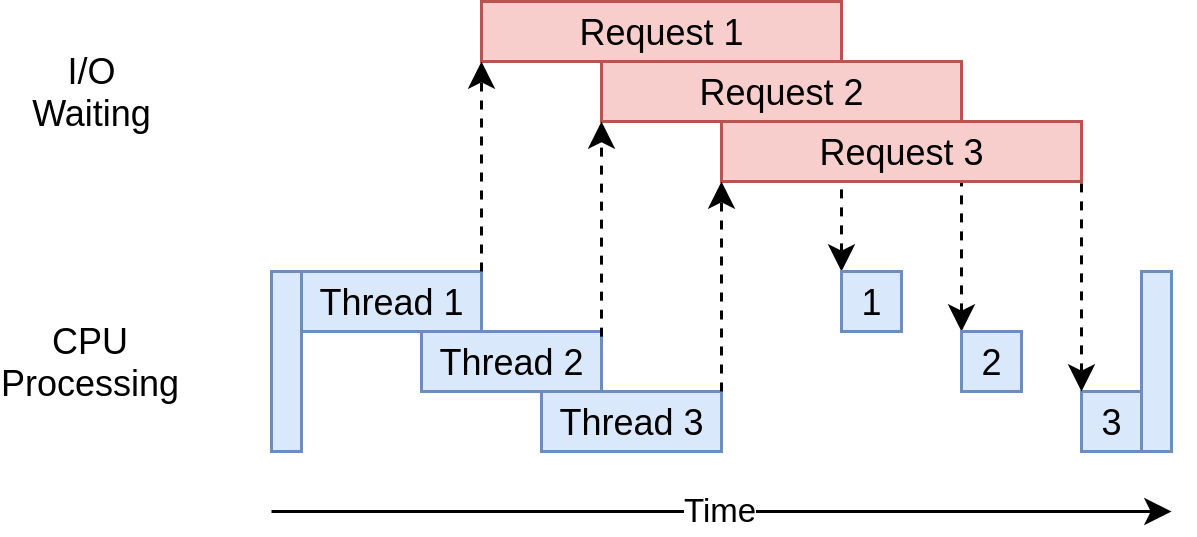

## qué tal?

Pros:
- Mejora notablemente los tiempos
- No bloquea el hilo principal

A tener en cuenta:
- Los threads son manejados por el SO. El SO es quien decide a que thread del sistema darle ejecución.
- Hay microdelays por context switching. (En 100 tareas no se nota pero en >8000 si, por decir algo)
- Cualquier variable compartida entre los threads tiene que ser protegida (tiene que ser **thread-safe**). Por lo tanto, requiere manejo de primitivas de sincronización de acceso/escritura. ie. (locks, semaforos, etc)

Cons:
- No ayuda en tareas CPU-bound. El GIL (Global Interpreter Lock) de Python hace que los threads se ejecuten sincrónicamente, o sea, lo mismo que correr solo en un solo thread.
- Para tareas CPU-bound conviene usar `multiprocessing` o `concurrent.futures.ThreadProcessPool`

## Ejemplo usando asyncio

In [14]:
import asyncio
import httpx
import time

In [15]:
async def fetch(session, url):
    response = await session.get(url)
    print(f"[{response.status_code}] {url}")

In [16]:
async def fetch_urls_with_asyncio():
    async with httpx.AsyncClient() as session:
        tasks = [
            fetch(session, url)
            for url in urls
        ]
        await asyncio.gather(*tasks)

In [17]:
start = time.time()
await fetch_urls_with_asyncio()
end = time.time()
print(f"Wall time: {(end - start):.2f}s")

[200] https://jsonplaceholder.typicode.com/posts/2
[200] https://jsonplaceholder.typicode.com/posts/16
[200] https://jsonplaceholder.typicode.com/posts/5
[200] https://jsonplaceholder.typicode.com/posts/7
[200] https://jsonplaceholder.typicode.com/posts/1
[200] https://jsonplaceholder.typicode.com/posts/15
[200] https://jsonplaceholder.typicode.com/posts/9
[200] https://jsonplaceholder.typicode.com/posts/18
[200] https://jsonplaceholder.typicode.com/posts/3
[200] https://jsonplaceholder.typicode.com/posts/17
[200] https://jsonplaceholder.typicode.com/posts/6
[200] https://jsonplaceholder.typicode.com/posts/19
[200] https://jsonplaceholder.typicode.com/posts/13
[200] https://jsonplaceholder.typicode.com/posts/4
[200] https://jsonplaceholder.typicode.com/posts/12
[200] https://jsonplaceholder.typicode.com/posts/10
[200] https://jsonplaceholder.typicode.com/posts/14
[200] https://jsonplaceholder.typicode.com/posts/11
[200] https://jsonplaceholder.typicode.com/posts/8
Wall time: 0.77s


## wow!
Pros:
- Tareas super livianas
- No hay context switch
- Todo ocurre en el mismo proceso/thread
- No requiere manejo de memoria compartida
- Hace que Python sea una solución competente (y simple) contra lenguages como Go

A tener en cuenta:
- Al ser cooperativo, significa que si una tarea es bloqueante, todas las otras lo serán. 
- Por lo tanto, es necesario que todo este pensado cooperativamente, inclusive las librerías a usar.

sync | async
--- | ---
redis | aioredis
requests | httpx / aiohttp
sleep | asyncio.sleep
mysqldb | aiomysql
psycopg | aiopg

...etc

A diferencia de los threads, en asyncio, cuando una tarea/corutina se queda esperando por IO, le cede el control al main loop de asyncio para que otra tarea/corutina pueda correr. 

El main loop no es mas que un objecto Python que maneja una cola de tareas.

A esto se le suele decir *multitasking cooperativo*.

### Mas info
- Entendiendo asyncio sin usar asyncio - https://www.youtube.com/watch?v=BenwwgMx3Hg
- Python Concurreny - https://realpython.com/python-concurrency/